In [53]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

In [54]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas

import geopandas as gpd

In [55]:
#importing data and reading it
telangana_fires_data = pd.read_csv("/content/telangana_fires.csv")

In [56]:
#reassigning a shorter name to ease of use
fire_data = telangana_fires_data

In [57]:
fire_data.head(3)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,18.3777,80.5314,318.6,1.0,1.0,2015-01-02,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0
1,17.5898,80.9893,315.4,1.2,1.1,2015-01-04,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0
2,17.6028,81.1612,311.8,1.2,1.1,2015-01-05,527,Terra,MODIS,46,6.03,299.8,6.0,D,0


In [58]:
#converting dates into years
fire_data["year"] = pd.DatetimeIndex(fire_data["acq_date"]).year
fire_data = fire_data.drop("acq_date", axis = 1)
fire_data.head(3)

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year
0,18.3777,80.5314,318.6,1.0,1.0,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0,2015
1,17.5898,80.9893,315.4,1.2,1.1,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0,2015
2,17.6028,81.1612,311.8,1.2,1.1,527,Terra,MODIS,46,6.03,299.8,6.0,D,0,2015


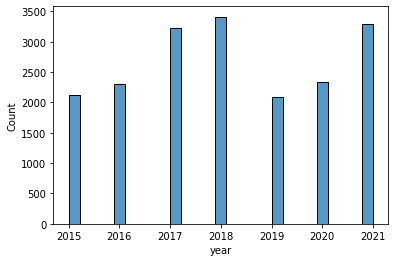

In [59]:
#plot for fires per year
sns.histplot(data = fire_data, x = "year")

We see that Cases of fire are increasing from 2015 to 2018. 
While we saw a drop into 2019, only to see a rise in 2020 and 2021 from the levels observed in 2019. 

There's a chance that cases might have been recorded low or there were less acts of planned fires during the Pandemic, Covid 19.

In [60]:
#Used geopandas to get coordinates in a spatial polygon form from the longitude and latitude values available in fire data 
fire_data["geometry"] = gpd.points_from_xy(fire_data["longitude"], fire_data["latitude"])

In [61]:
fire_data.head(2)

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,geometry
0,18.3777,80.5314,318.6,1.0,1.0,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0,2015,POINT (80.53140 18.37770)
1,17.5898,80.9893,315.4,1.2,1.1,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0,2015,POINT (80.98930 17.58980)


In [62]:
# Getting only useful features/ required features for the task
fire_area = gpd.GeoDataFrame(fire_data[["year", "geometry"]])

In [63]:
fire_area.head(3)

,year,geometry
0,2015,POINT (80.53140 18.37770)
1,2015,POINT (80.98930 17.58980)
2,2015,POINT (81.16120 17.60280)


In [64]:
#Importing India's shapefile, finding telangana and obtaining geospatial info. regarding the areas  
IndiaShapefile = gpd.read_file("/content/gadm40_IND_3.shp")
telangana = IndiaShapefile[IndiaShapefile["NAME_1"] == "Telangana"]

In [65]:
telangana_area_data = telangana[["NAME_2", "geometry"]]
telangana_area_data.head(2)

,NAME_2,geometry
1954,Adilabad,"POLYGON ((78.84434 19.75900, 78.84563 19.75835..."
1955,Adilabad,"POLYGON ((78.96471 19.57028, 78.95446 19.56272..."


In [66]:
a = telangana_area_data["NAME_2"].nunique()
print("Number of Adminstrative areas/ districts that saw fire:", a)

Number of Adminstrative areas/ districts that saw fire: 10


In [67]:
telangana_area_data = telangana_area_data.rename(columns = {"NAME_2" : "adm_name"})

In [68]:
#using spatial join to merge the area to the fire data
fire_area_merged = gpd.sjoin(fire_area, telangana_area_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  


In [69]:
fire_area_merged.head(3)

,year,geometry,index_right,adm_name
0,2015,POINT (80.53140 18.37770),1977,Khammam
36,2015,POINT (80.40040 18.50930),1977,Khammam
39,2015,POINT (80.52920 18.38910),1977,Khammam


In [70]:
fire_area_merged.columns

Index(['year', 'geometry', 'index_right', 'adm_name'], dtype='object')

In [71]:
fire_area_merged = fire_area_merged[["adm_name", "year"]]

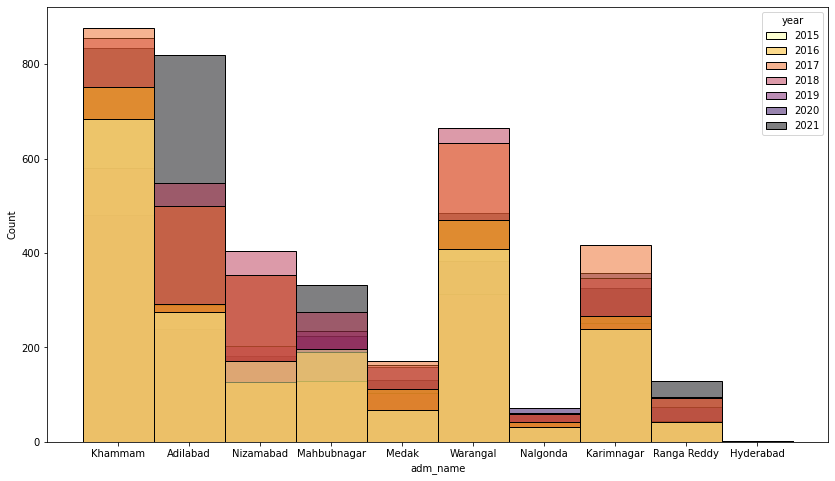

In [86]:
plt.figure(figsize = (14,8))
palette = sns.color_palette("bright")
sns.histplot(data = fire_area_merged, x = "adm_name", hue = "year", palette = "inferno_r")

In [87]:
fire_area_merged.head(2)

,adm_name,year
0,Khammam,2015
36,Khammam,2015


In [88]:
fire_area_merged = fire_area_merged.groupby(["adm_name", "year"], as_index = False).size()
fire_area_merged.head(3)

,adm_name,year,size
0,Adilabad,2015,276
1,Adilabad,2016,293
2,Adilabad,2017,499


In [90]:
fire_area_merged = fire_area_merged.rename(columns = {"size" : "fireCount"})

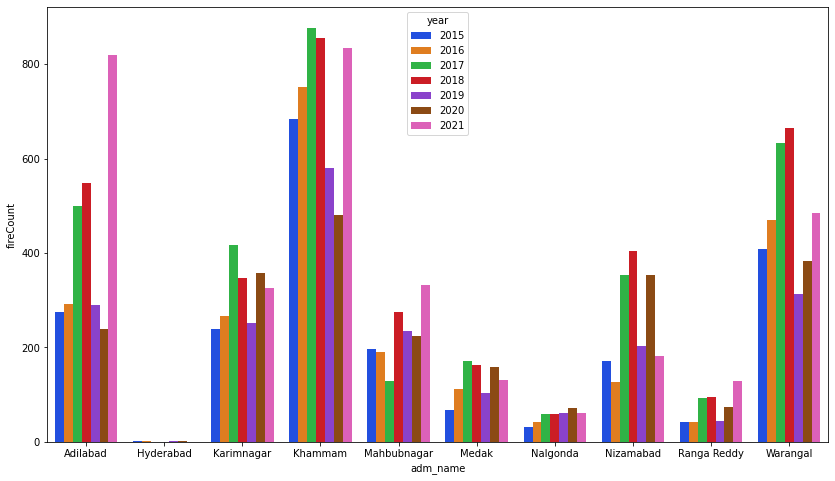

In [93]:
plt.figure(figsize = (14,8))
sns.barplot(data = fire_area_merged, x = "adm_name" , y = "fireCount" , hue = "year", palette = "bright")

In [94]:
import json
fire_area_merged.to_json(r'/content/Task1_json.json', orient = 'split')

In [101]:
fire_area_merged.sort_values(by ="fireCount", ascending = False)

,adm_name,year,fireCount
20,Khammam,2017,877
21,Khammam,2018,855
24,Khammam,2021,834
6,Adilabad,2021,819
19,Khammam,2016,752
...,...,...,...
39,Nalgonda,2015,32
9,Hyderabad,2019,2
8,Hyderabad,2016,2
10,Hyderabad,2020,1
